In [46]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /Users/antolifer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Get Data from the Dataset

In [47]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)

with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_businesses = pd.read_json(data_json_str)
/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_users = pd.read_json(data_json_str)
/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews = pd.read_json(data_json_str)


### Tokenize the Reviews

In [24]:
## iterate through each review and tokenize each review
for index, row in df_reviews.iterrows():
    review = row['text']
    tokens = word_tokenize(review)
    # remove punctuation
    words = [word for word in tokens if word.isalpha()]
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    # stemming
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    df_reviews.at[index, 'text'] = ' '.join(words)

## create a new dataframe with the tokenized reviews
df_reviews_tokenized = df_reviews[['review_id', 'text', 'date']]
df_reviews_tokenized.to_json('./datasets/review_dataset_new_orleans_tokenized.json', orient='records', lines=True)


### Sentiment Analysis

In [25]:
import json
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Create Get Sentiment Function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# Load Tokenized Reviews
with open('./datasets/review_dataset_new_orleans_tokenized.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_tokenized = pd.read_json(data_json_str)

# Get Sentiment for Each Review
df_reviews_tokenized['sentiment'] = df_reviews_tokenized['text'].apply(get_sentiment)

# Print Sentiment Distribution
print(df_reviews_tokenized['sentiment'].value_counts())
    

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2294914106.py:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_tokenized = pd.read_json(data_json_str)


sentiment
1    608110
0     27254
Name: count, dtype: int64


In [26]:
# Save Sentiment to JSON
df_reviews_tokenized[['review_id', 'sentiment', 'date']].to_json('./datasets/review_dataset_new_orleans_sentiment.json', orient='records', lines=True)

# Load Sentiment
with open('./datasets/review_dataset_new_orleans_sentiment.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_sentiment = pd.read_json(data_json_str)

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/4266901064.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_sentiment = pd.read_json(data_json_str)


### Time Series Analysis

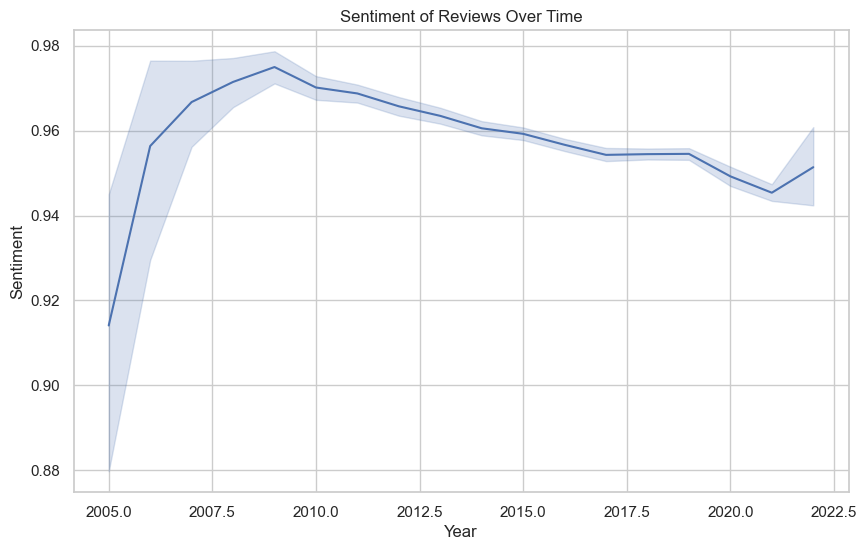

In [35]:
# For this section we need to track evolution of the sentiment of the reviews over time
# We need to merge the sentiment with the reviews
df_reviews_sentiment = df_reviews_sentiment.rename(columns={'review_id': 'id'})

df_reviews_sentiment['date'] = pd.to_datetime(df_reviews_sentiment['date'])
df_reviews_sentiment = df_reviews_sentiment.sort_values(by='date')

# load the reviews by year
df_reviews_sentiment['year'] = df_reviews_sentiment['date'].dt.year

# plot the sentiment over time as a time series!
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='sentiment', data=df_reviews_sentiment)
plt.title('Sentiment of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.show()

AttributeError: module 'numpy' has no attribute 'count'

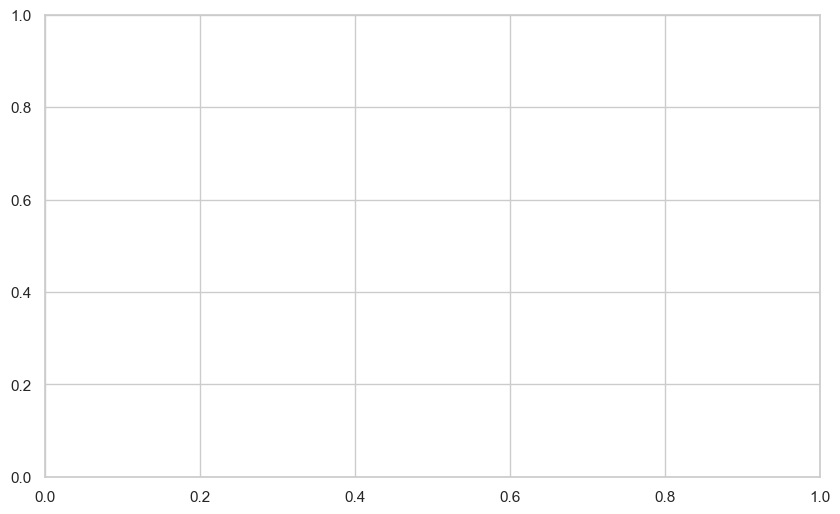

In [45]:
# Show frequency of positive and negative reviews over time but as a time series
# Where the negative reviews are 0 and positive reviews are 1 and are different lines
# The x axis should be the date and the y should be the frequency of the reviews (different lines for positive and negative)

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='sentiment', data=df_reviews_sentiment, estimator='count', hue='sentiment')
plt.title('Frequency of Positive and Negative Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


